# 畳み込みニューラルネットワーク(CNN)のCIFAR10データセットへの適用

##本チュートリアルではchainerを利用してニューラルネットワークの実装を確認，学習および評価を行います．　環境としてはGoogle が提供する Google Colaboratory上でおこないます． GPU上で処理を行うため，colaboratoryの[ランタイム]->[ランタイムのタイプを変更]からハードウェアアクセラレータをGPUにしてください．

Chainerでニューラルネットワークを学習するために必要なモジュールや関数をインポートします．

In [ ]:
import numpy as np
import time

from chainer import cuda,optimizers
import chainer, chainer
from chainer import Chain, Variable
import chainer.functions as F
import chainer.links as L

GPUが利用できるか確認します．

In [3]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


次に学習データを読み込みます．CIFAR10データセットは中規模な一般物体認識のデータセットであり，chainerでは CIFAR10
データセットを取得し，学習するためのフォーマットに変換してくれます．データセットには学習用とテスト用のデータに別れており，それぞれtrain_dataset, test_datasetとします．また，それらには画像データと教師ラベルがあり，それらをtrain_xとtrain_y，test_xとtest_yとします．

In [ ]:
train_dataset, test_dataset = chainer.datasets.get_cifar10()
train_x, train_y = train_dataset._datasets
test_x, test_y = test_dataset._datasets

学習データのサイズを確認します．学習データサイズは５万枚，１つのデータのサイズは3x32x32の画像のような形式となっています．これは32x32ピクセルのカラー画像という意味になります．


In [5]:
print (train_x.shape, train_y.shape)

(50000, 3, 32, 32) (50000,)


CIFAR10データセットに含まれる画像を表示してみます．ここでは，matplotlibで複数の画像を表示させるプログラムを利用します．

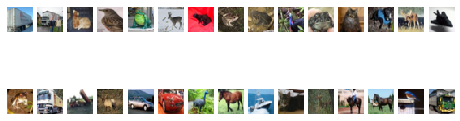

In [6]:
import cv2
import matplotlib.pyplot as plt
import os.path

cols =15
rows = 2

def clearLabel(_ax):
    _ax.tick_params(labelbottom="off",bottom="off")
    _ax.tick_params(labelleft="off",left="off")
    _ax.set_xticklabels([]) 
    _ax.axis('off')
    return _ax

def readImage(idx):
    bimg = train_x[idx].copy()
    label = train_y[idx]
    bimg = bimg.reshape(3, 32,32)
    return bimg.transpose(1,2,0)

fig = plt.figure()

num = 0
for r in range(rows):
    for c in range(cols):
        ax1 = fig.add_subplot(r+1, cols, c+1)
        clearLabel(ax1)
        show_img1 = readImage(num)
        plt.imshow(show_img1)
        num+=1

畳み込みニューラルネットワークを定義します．ここでは，畳み込み層２層，全結合層３層から構成されるネットワークとします．１層目の畳み込み層は入力チャンネル数が１，出力する特徴マップ数が16，畳み込むフィルタサイズが3x3です．２層目の畳み込み層は入力チャネル数が16．出力する特徴マップ数が32，畳み込むフィルタサイズは同じく3x3です．１つ目の全結合層は入力ユニット数は不定とし，出力は1024としています．次の全結合層入力，出力共に1024，出力層は入力が1024，出力が10です．これらの各層の構成を\__init\__関数で定義します．
次に，\__call\__関数では，定義した層を接続して処理するように記述します．\__call\__関数の引数xは入力データです．それを\__init\__関数で定義したconv1に与え，その出力を活性化関数であるrelu関数に与えます．そして，その出力をmax_pooling_2dに与えて，プーリング処理結果をhとして出力します．hはconv2に与えられて畳み込み処理とプーリング処理を行います．そして，出力hをl1に与えて全結合層の処理を行います．最終的にl3の全結合層の処理を行った出力hを戻り値としています．


In [ ]:
class CNN(Chain):
    def __init__(self):
        super(CNN, self).__init__(
            conv1 = L.Convolution2D(3, 32, 3, pad=1), 
            conv2 = L.Convolution2D(32, 64, 3, pad=1), 
            l1 = L.Linear(None, 2048),
            l2 = L.Linear(2048, 2048),
            l3 = L.Linear(2048, 10)
        )

    def __call__(self, x):
        h = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h = F.max_pooling_2d(F.relu(self.conv2(h)), 2)
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        return h

畳み込みネットワークモデルを定義します．学習を行う際の最適化方法としてモーメンタムSGD(モーメンタム付き確率的勾配降下法）を利用します．また，学習率を0.05として引数に与えます．そして，最適化方法のsetup関数にネットワークモデルを与えます．ここでは，GPUで学習を行うために，modelをGPUに送るto_gpu関数を利用しています．また，GPUに対応した行列演算モジュールのcupyを呼び出しています．

In [ ]:
gpu_id = 0 
xp = cuda.cupy
model = CNN()
model.to_gpu(gpu_id)

learning_rate = 0.05
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.WeightDecay(5e-4))

学習およびテストデータをcupyの形式に変換します．cupyはnumpyと互換性があります．

In [ ]:
train_x = xp.array(train_x, dtype=xp.float32)
train_y = xp.array(train_y, dtype = xp.int32)
test_x = xp.array(test_x, dtype=xp.float32)
test_y = xp.array(test_y, dtype = xp.int32)

１回の誤差を算出するデータ数（ミニバッチサイズ）を32，学習エポック数を100とします．CIFAR10の学習データサイズを取得し，１エポック内における更新回数を求めます．学習率は25エポックごとに0.5倍して徐々に小さくしていくようにします．学習データは毎エポックでランダムに利用するため，numpyのpermutationという関数を利用します．各更新において，学習用データと教師データをそれぞれxとtとし，to_gpu関数でGPUに転送します．学習モデルにxを与えて各クラスの確率yを取得します．各クラスの確率yと教師ラベルtとの誤差をsoftmax coross entropy誤差関数で算出します．また，認識精度も算出します．そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [11]:
batch_size = 32
epoch_num = 100
train_data_num = train_x.shape[0]
iter_one_epoch = int(train_x.shape[0]/batch_size)

start = time.time()
for epoch in range(epoch_num):
    num_iter = 0
    sum_loss = 0
    sum_accuracy = 0
#     if (epoch+1) % 25 == 0:
#         optimizer.lr *= 0.5
    perm = xp.random.permutation(train_data_num)
    for i in range(0, train_data_num, batch_size):
        x = Variable(cuda.to_gpu(train_x[perm[i:i+batch_size]]))
        t = Variable(cuda.to_gpu(train_y[perm[i:i+batch_size]]))
        y = model(x)        
        model.zerograds()
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        loss.backward()
        optimizer.update()
        sum_loss += loss.data
        sum_accuracy += acc.data
        num_iter +=1
    elapsed_time = time.time() - start
    print("epoch: {}, mean loss: {}, mean accuracy: {},  elapsed_time :{}".format(epoch+1,
                                                                                  sum_loss/num_iter,
                                                                                  sum_accuracy/num_iter,
                                                                                  elapsed_time))

    if (epoch+1) % 10 == 0:
        chainer.serializers.save_hdf5('caifr10_epoch{}.npz'.format(epoch), model, compression=6)

epoch: 1, mean loss: 0.20637634, mean accuracy: 0.9278031,  elapsed_time :28.788092613220215
epoch: 2, mean loss: 0.1915591, mean accuracy: 0.93392116,  elapsed_time :56.91785383224487
epoch: 3, mean loss: 0.19330914, mean accuracy: 0.93336135,  elapsed_time :85.25839042663574
epoch: 4, mean loss: 0.19233379, mean accuracy: 0.9335213,  elapsed_time :114.59557032585144
epoch: 5, mean loss: 0.18884602, mean accuracy: 0.93588054,  elapsed_time :143.84851169586182
epoch: 6, mean loss: 0.18826298, mean accuracy: 0.93584055,  elapsed_time :173.30855894088745
epoch: 7, mean loss: 0.19014415, mean accuracy: 0.9347209,  elapsed_time :202.88041639328003
epoch: 8, mean loss: 0.18456288, mean accuracy: 0.9367802,  elapsed_time :232.0376260280609
epoch: 9, mean loss: 0.18655187, mean accuracy: 0.9349008,  elapsed_time :261.82146549224854
epoch: 10, mean loss: 0.17700131, mean accuracy: 0.9396593,  elapsed_time :292.080628156662
epoch: 11, mean loss: 0.1836676, mean accuracy: 0.93746,  elapsed_time 

学習できたネットワークモデルを利用して評価を行います．

In [12]:
cnt = 0
test_data_num = test_x.shape[0]
for i in range(test_data_num):
    x = Variable(cuda.to_gpu(test_x[i].reshape(1,3,32,32)))
    t = test_y[i]
    y = model(x)
    y = np.argmax(y.data[0])
    if t == y:
        cnt += 1
 
print("test accuracy: {}".format(cnt/test_data_num))

test accuracy: 0.6965


## 課題　
### 以下の課題に取り組みましょう

1  ネットワーク構造を変えて実験しましょう． 

   まず，1層目の畳み込み層のフィルタ数を32にしましょう．また，2層目の畳み込み層のフィルタ数を64にしましょう．
   
   次に，中間層のユニット数を2048にしましょう．

2  最適化の方法をAdamに変えて実験しましょう．


3  エポック数やミニバッチサイズを変えて実験しましょう．

  まず，ミニバッチサイズを128にしましょう．
  
  次に，エポック数を50にしましょう．

4  GPUの有無による速度の差を比較しましょう


##別のコードの書き方

前回のCNNによるMNISTの文字認識と同様にTrainerを利用したプログラムを作成します．　Trainerを利用する場合と利用しない場合による処理時間の違いを確認しましょう．

In [ ]:
import numpy as np
import chainer
from chainer import cuda, optimizers
from chainer import Chain, Variable
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

batch_size = 32
epoch_num = 100

learning_rate = 0.05


model = L.Classifier(CNN())
model.to_gpu() 
optimizer = chainer.optimizers.MomentumSGD(lr=learning_rate, momentum=0.9)
optimizer.setup(model)  
  
train_dataset, test_dataset = chainer.datasets.get_cifar10()

train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size)
test_iter = chainer.iterators.SerialIterator(test_dataset, batch_size,    repeat=False, shuffle=False)

updater = training.updaters.StandardUpdater( train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (epoch_num, 'epoch'), out='result')

trainer.extend(extensions.Evaluator(test_iter, model, device=0))
trainer.extend(extensions.ExponentialShift('lr', 0.5),  trigger=(25, 'epoch'))

trainer.extend(extensions.dump_graph('main/loss'))

trainer.extend(extensions.LogReport())

trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],  'epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],'epoch', file_name='accuracy.png'))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

trainer.run()